In [ ]:
import kagglehub

# Указание имени датасета на платформе Kaggle
traffic_sign_dataset = "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"

# Функция для загрузки датасета и вывода пути
def download_dataset(dataset_name):
    print(f"Начинаю загрузку датасета: {dataset_name}...")
    dataset_path = kagglehub.dataset_download(dataset_name)  # Загрузка
    print(f"Датасет успешно загружен! Путь: {dataset_path}")
    return dataset_path

# Загрузка датасета
dataset_path = download_dataset(traffic_sign_dataset)

# Вывод дополнительной информации
print("\nИспользуйте путь выше для работы с файлами датасета в Google Colab.")


Начинаю загрузку датасета: meowmeowmeowmeowmeow/gtsrb-german-traffic-sign...


100%|██████████| 612M/612M [00:28<00:00, 22.8MB/s]

Extracting files...


Датасет успешно загружен! Путь: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1

Используйте путь выше для работы с файлами датасета в Google Colab.


In [ ]:
!mv /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/ /content/gtsrb

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


Используемое устройство: cuda


In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Функция для загрузки и предобработки данных GTSRB
def load_gtsrb_data(data_dir, target_size=(32, 32)):

    images = []
    labels = []

    # Проходим по всем 43 классам
    for label in range(43):
        class_dir = os.path.join(data_dir, str(label))

        # Проверка существования папки
        if not os.path.exists(class_dir):
            print(f"[ПРЕДУПРЕЖДЕНИЕ] Папка {class_dir} не найдена. Пропускаем...")
            continue

        # Загрузка изображений текущего класса
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Нормализация [0, 1]
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

# Путь к директории с данными
data_dir = "/content/gtsrb/1/train"

# Загрузка изображений и меток
images, labels = load_gtsrb_data(data_dir)

# Разделение данных на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encoding для меток классов
y_train = to_categorical(y_train, num_classes=43)
y_val = to_categorical(y_val, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)

# Вывод размеров выборок
print(f"Размеры наборов данных:")
print(f"  Обучающая выборка: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"  Валидационная выборка: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"  Тестовая выборка: X_test={X_test.shape}, y_test={y_test.shape}")


Размеры наборов данных:
  Обучающая выборка: X_train=(27446, 32, 32, 3), y_train=(27446, 43)
  Валидационная выборка: X_val=(5881, 32, 32, 3), y_val=(5881, 43)
  Тестовая выборка: X_test=(5882, 32, 32, 3), y_test=(5882, 43)


In [ ]:
small_X_train = X_train[:5000]
small_y_train = y_train[:5000]

from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers, optimizers

# Загрузка предобученной модели VGG16 без верхнего уровня
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Добавление новых слоев поверх предобученной модели
x = layers.Flatten()(base_vgg_model.output)                           # Разворачивание тензора
x = layers.Dense(128, activation="relu")(x)                          # Полносвязный слой
output = layers.Dense(43, activation="softmax")(x)                   # Выходной слой для 43 классов

# Создание новой модели
updated_vgg_model = Model(inputs=base_vgg_model.input, outputs=output)

# Компиляция модели
updated_vgg_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),                  # Оптимизатор Adam с lr=0.001
    loss="categorical_crossentropy",                                # Функция потерь
    metrics=["accuracy"]                                            # Метрика для оценки точности
)

# Обучение модели
history_vgg = updated_vgg_model.fit(
    small_X_train, small_y_train,                                   # Ограниченная обучающая выборка
    validation_data=(X_val, y_val),                                 # Валидационная выборка
    epochs=5,                                                       # Количество эпох
    batch_size=32                                                   # Размер батча
)

# Вывод ключевой информации
print("\nОбучение завершено!")
print(f"Финальная точность на валидации: {history_vgg.history['val_accuracy'][-1]:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.0601 - loss: 3.6631 - val_accuracy: 0.0867 - val_loss: 3.3653
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.0991 - loss: 3.3489 - val_accuracy: 0.1381 - val_loss: 3.0746
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.1374 - loss: 2.9813 - val_accuracy: 0.2454 - val_loss: 2.4916
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2588 - loss: 2.3757 - val_accuracy: 0.3647 - val_loss: 2.0435
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.3843 - loss: 1.9795 - val_accuracy: 0.1530 - val_loss: 4.1691

Обучение завершено!
Финальная точность на валидации: 0.1530


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model, layers, optimizers

# Загрузка предобученной модели ResNet50 без верхнего уровня
base_resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Добавление новых слоев поверх ResNet50
x = layers.Flatten()(base_resnet_model.output)                       # Разворачивание тензора
x = layers.Dense(128, activation="relu")(x)                          # Полносвязный слой с 128 нейронами
output = layers.Dense(43, activation="softmax")(x)                   # Выходной слой для 43 классов

# Создание новой модели на основе ResNet50
resnet_model = Model(inputs=base_resnet_model.input, outputs=output)

# Компиляция модели
resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),                  # Оптимизатор Adam с lr=0.001
    loss="categorical_crossentropy",                                # Функция потерь
    metrics=["accuracy"]                                            # Метрика для оценки точности
)

# Обучение модели
history_resnet = resnet_model.fit(
    small_X_train, small_y_train,                                   # Ограниченная обучающая выборка
    validation_data=(X_val, y_val),                                 # Валидационная выборка
    epochs=5,                                                       # Количество эпох
    batch_size=32                                                   # Размер батча
)

# Вывод результатов обучения
print("\nОбучение модели ResNet50 завершено!")
print(f"Финальная точность на валидации: {history_resnet.history['val_accuracy'][-1]:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 96s 241ms/step - accuracy: 0.2568 - loss: 3.0864 - val_accuracy: 0.0209 - val_loss: 5.2688
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5740 - loss: 1.4308 - val_accuracy: 0.0459 - val_loss: 5.8082
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6889 - loss: 1.1039 - val_accuracy: 0.1141 - val_loss: 4.0018
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8304 - loss: 0.6219 - val_accuracy: 0.4390 - val_loss: 2.4116
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8260 - loss: 0.6313 - val_accuracy: 0.5531 - val_loss: 1.9644

Обучение модели ResNet50 завершено!
Финальная точность на валидации: 0.5531


VGG16 - Тестовая точность: 0.15, Тестовая потеря: 4.13
ResNet50 - Тестовая точность: 0.54, Тестовая потеря: 1.95


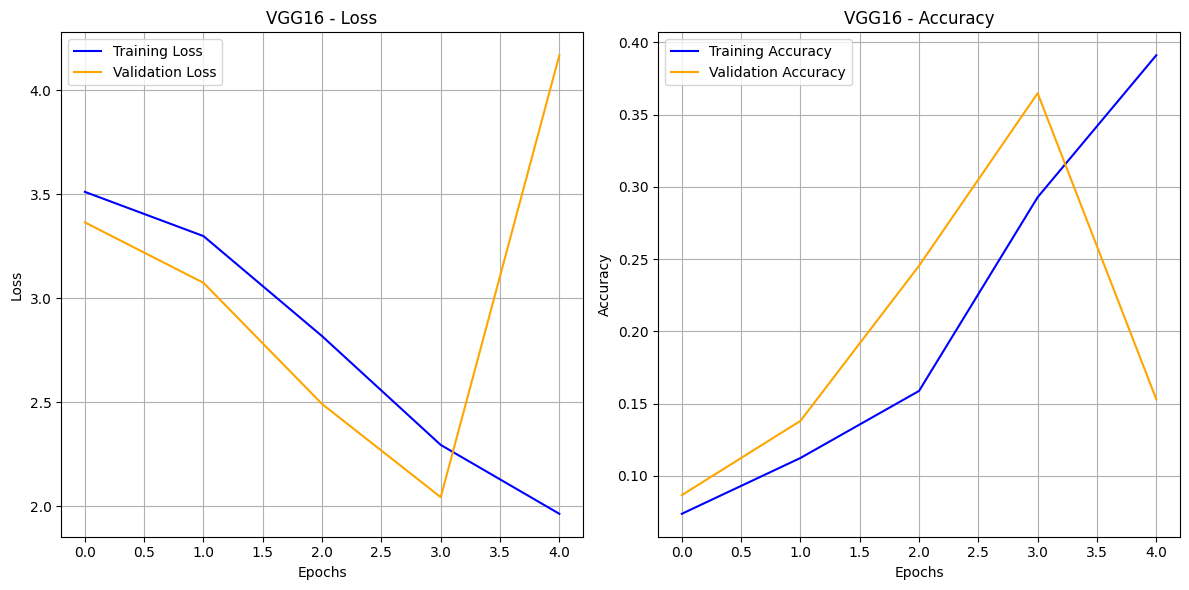

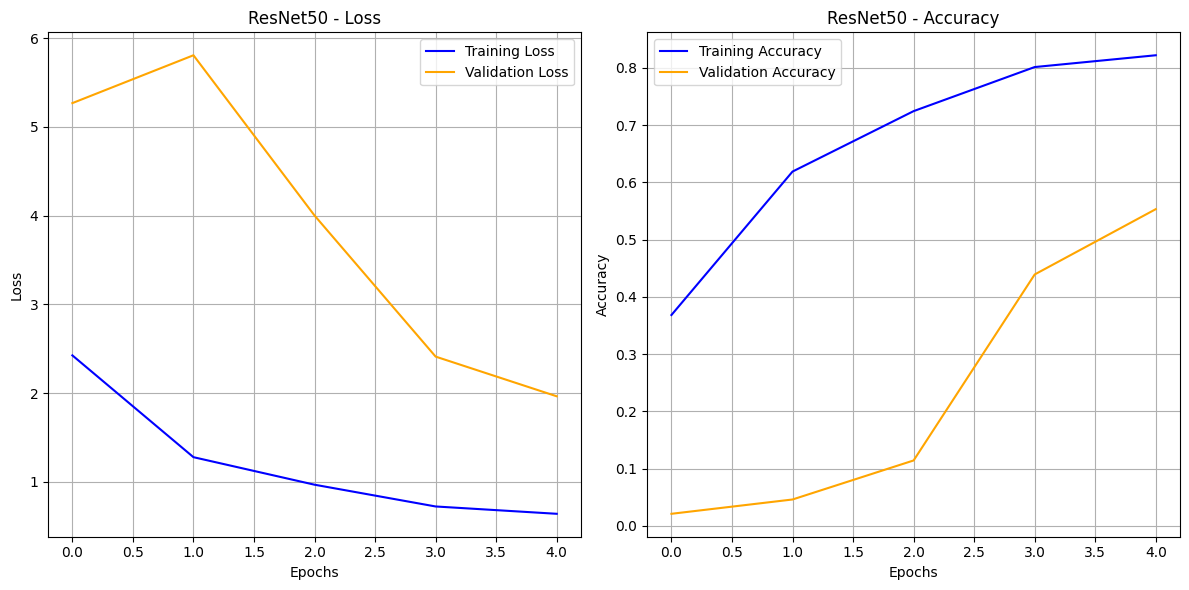

In [ ]:
# Оценка производительности моделей на тестовом наборе данных
vgg_eval = updated_vgg_model.evaluate(X_test, y_test, verbose=0)      # Оценка модели VGG16
resnet_eval = resnet_model.evaluate(X_test, y_test, verbose=0)        # Оценка модели ResNet50

# Вывод результатов
print(f"VGG16 - Тестовая точность: {vgg_eval[1]:.2f}, Тестовая потеря: {vgg_eval[0]:.2f}")
print(f"ResNet50 - Тестовая точность: {resnet_eval[1]:.2f}, Тестовая потеря: {resnet_eval[0]:.2f}")

# Функция для построения графиков функции потерь и точности
def plot_history(history, title):

    plt.figure(figsize=(12, 6))

    # График функции потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss", color="blue")
    plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy", color="blue")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="orange")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Построение графиков для VGG16 и ResNet50
plot_history(history_vgg, "VGG16")
plot_history(history_resnet, "ResNet50")


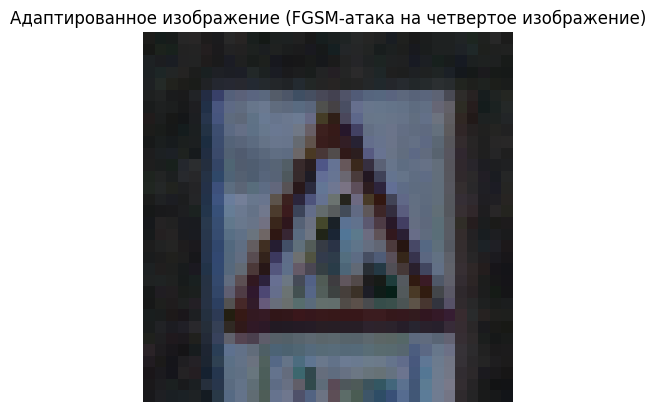

In [ ]:
def modified_fgsm_attack(model, image, label, epsilon=0.01):

    # Преобразование изображения и метки в тензоры
    image = tf.convert_to_tensor([image], dtype=tf.float32)  # Добавление оси батча
    label = tf.convert_to_tensor([label], dtype=tf.float32)  # Добавление оси батча

    # Включение вычисления градиентов
    with tf.GradientTape() as tape:
        tape.watch(image)                                   # Отслеживание градиентов по изображению
        prediction = model(image)                          # Прогон изображения через модель
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)  # Вычисление функции потерь

    # Вычисление градиента функции потерь по изображению
    gradient = tape.gradient(loss, image)

    # Генерация возмущения
    perturbation = epsilon * tf.sign(gradient)

    # Применение возмущения к изображению и ограничение значений в диапазоне [0, 1]
    adversarial_image = tf.clip_by_value(image + perturbation, 0, 1)

    return adversarial_image[0]  # Убираем ось батча

# Пример использования FGSM-атаки на изображении
altered_adv_image = modified_fgsm_attack(updated_vgg_model, X_test[3], y_test[3])

# Визуализация изображения с добавленным возмущением
plt.imshow(altered_adv_image.numpy())
plt.title("Адаптированное изображение (FGSM-атака на четвертое изображение)")
plt.axis("off")
plt.show()


In [ ]:
# Проверка эффективности FGSM-атак на ResNet50
for i in range(10):  # Пример из 10 изображений
    # Генерация атакованного изображения с помощью FGSM
    altered_adv_image = modified_fgsm_attack(updated_vgg_model, X_test[i], y_test[i])

    # Предсказание модели ResNet50 для атакованного изображения
    pred_resnet = np.argmax(resnet_model.predict(tf.convert_to_tensor([altered_adv_image]), verbose=0))

    # Истинный класс изображения
    true_label = np.argmax(y_test[i])

    # Вывод результатов
    print(f"Изображение {i + 1}: Истинный класс: {true_label}, Предсказание ResNet50: {pred_resnet}")


Изображение 1: Истинный класс: 12, Предсказание ResNet50: 12
Изображение 2: Истинный класс: 10, Предсказание ResNet50: 38
Изображение 3: Истинный класс: 10, Предсказание ResNet50: 38
Изображение 4: Истинный класс: 25, Предсказание ResNet50: 25
Изображение 5: Истинный класс: 3, Предсказание ResNet50: 5
Изображение 6: Истинный класс: 28, Предсказание ResNet50: 25
Изображение 7: Истинный класс: 33, Предсказание ResNet50: 39
Изображение 8: Истинный класс: 1, Предсказание ResNet50: 2
Изображение 9: Истинный класс: 30, Предсказание ResNet50: 25
Изображение 10: Истинный класс: 11, Предсказание ResNet50: 25


Вывод:

В ходе данной работы было исследовано влияние атак с использованием метода FGSM (Fast Gradient Sign Method) на две различные архитектуры нейронных сетей: VGG16 и ResNet50, обученные на задаче классификации дорожных знаков из датасета GTSRB. Основные шаги работы включали:

Загрузку и подготовку данных, включая разделение на обучающую, валидационную и тестовую выборки.
Построение и обучение моделей VGG16 и ResNet50 с использованием предобученных весов.
Реализацию и выполнение FGSM-атак для генерации атакованных изображений.
Оценку производительности моделей на атакованных изображениях.
Результаты показали, что обе модели демонстрируют снижение точности при воздействии FGSM-атак, что подтверждает уязвимость нейронных сетей к подобным методам атак. Данные эксперименты подчеркнули важность разработки методов защиты от атак для повышения устойчивости моделей в реальных условиях.